# S&P 600 Risk-Driven Anomaly Detection

This notebook demonstrates a supervised ML approach for detecting equity return anomalies using feature engineering, statistical labeling, and Random Forest classification, with applications in portfolio risk management and stress testing.

In [1]:
import pandas as pd
import numpy as np

from google.colab import files
uploaded = files.upload()

# Load the dataset
df = pd.read_csv("SP600_StockData_With_Interst_CPI_VIX_marketstress_Credit_Spread.csv")

Saving SP600_StockData_With_Interst_CPI_VIX_marketstress_Credit_Spread.csv to SP600_StockData_With_Interst_CPI_VIX_marketstress_Credit_Spread.csv


## Data Preparation & Feature Engineering

This section prepares the stock return dataset and constructs key features for anomaly detection, including rolling volatility, drawdown, volume z-score, and correlation with sector ETFs. Statistical labels for return, volume, and volatility anomalies are also generated for downstream modeling.

In [26]:
# Parse dates and ensure chronological order within each ticker
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])

# Calculate log returns for each ticker
df['adj_close_shifted'] = df.groupby('Ticker')['Adj Close'].shift(1)
df['log_return'] = np.log(df['Adj Close'] / df['adj_close_shifted'])

# Feature: 20-day rolling volatility of log returns
df['rolling_vol_20'] = df.groupby('Ticker')['log_return'].transform(
    lambda x: x.rolling(window=20).std()
)

# Feature: 20-day rolling drawdown from local maximum
def rolling_drawdown(prices, window=20):
    roll_max = prices.rolling(window=window, min_periods=1).max()
    return prices / roll_max - 1.0

df['drawdown_20'] = df.groupby('Ticker')['Adj Close'].transform(
    lambda x: rolling_drawdown(x, window=20)
)

# Feature: 20-day rolling z-score of volume (standardized within each ticker)
df['volume_zscore_20'] = df.groupby('Ticker')['Volume'].transform(
    lambda x: (x - x.rolling(window=20).mean()) / x.rolling(window=20).std()
)

# Feature: 20-day rolling correlation of each stock's return with its sector ETF return
df = df.sort_values(by=['Sector ETF', 'Date'])  # Ensure ETF group is ordered by date
df['etf_return'] = df.groupby('Sector ETF')['ETF_Close'].transform(
    lambda x: np.log(x / x.shift(1))
)

def calc_rolling_corr(group):
    return group['log_return'].rolling(20).corr(group['etf_return'])

df['rolling_corr_20'] = df.groupby('Ticker').apply(calc_rolling_corr).reset_index(level=0, drop=True)

# Label: Return anomaly (absolute deviation exceeds 2 standard deviations over rolling window)
ROLLING_WINDOW = 20
RETURN_SIGMA = 2

df['return_mean'] = df.groupby('Ticker')['log_return'].transform(lambda x: x.rolling(ROLLING_WINDOW).mean())
df['return_std'] = df.groupby('Ticker')['log_return'].transform(lambda x: x.rolling(ROLLING_WINDOW).std())
df['label_return'] = ((df['log_return'] - df['return_mean']).abs() > RETURN_SIGMA * df['return_std']).astype(int)

/tmp/ipython-input-26-3923425205.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['rolling_corr_20'] = df.groupby('Ticker').apply(calc_rolling_corr).reset_index(level=0, drop=True)


## Supervised Anomaly Detection:  Random Forest
A supervised machine learning approach is employed to detect return-driven anomalies at the stock level.  
The Random Forest classifier is trained on rolling statistical, technical, and macroeconomic features, using statistically defined anomaly labels as targets.


In [3]:
# Display return anomaly label distribution
print("Return anomalies detected:\n", df['label_return'].value_counts())

Return anomalies detected:
 label_return
0    700838
1     35002
Name: count, dtype: int64


### More Features for Return anomaly detection

In [4]:
# Rolling statistics of log returns (20-day window)
df['return_rolling_mean'] = df.groupby('Ticker')['log_return'].transform(lambda x: x.rolling(20).mean())
df['return_rolling_std'] = df.groupby('Ticker')['log_return'].transform(lambda x: x.rolling(20).std())
df['return_rolling_skew'] = df.groupby('Ticker')['log_return'].transform(lambda x: x.rolling(20).skew())
df['return_rolling_kurt'] = df.groupby('Ticker')['log_return'].transform(lambda x: x.rolling(20).kurt())

# Moving average and momentum features
df['sma_20'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(20).mean())
df['ema_20'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
df['momentum_5'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: x.diff(5))

# Feature list for return anomaly model (technical, macro, volatility)
return_feature_cols = [
    'return_rolling_mean', 'return_rolling_std', 'return_rolling_skew', 'return_rolling_kurt',
    'sma_20', 'ema_20', 'momentum_5',
    'rolling_vol_20', 'drawdown_20', 'volume_zscore_20', 'rolling_corr_20',
    '2 Yr', 'CPI', 'VIX', 'Credit_Spread', 'Market_Stress_Index'
]

In [5]:
# Prepare train/test data for return anomaly detection
X = df[return_feature_cols]
y = df.loc[X.index, 'label_return']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Threshold Adjustment and Model Evaluation
The classification threshold for return anomaly detection is lowered to 0.25 to increase sensitivity to rare events. The model's performance is evaluated with a confusion matrix and classification report.

In [6]:
# Random Forest (class_weight = 'balanced')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model_1 = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)

print("Random Forest (class_weight = 'balanced')")
print(f"Accuracy: {accuracy_score(y_test, y_pred_1):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_1))
print("Classification Report:\n", classification_report(y_test, y_pred_1))

Random Forest (class_weight = 'balanced')
Accuracy: 0.9589
Confusion Matrix:
 [[139827    341]
 [  5704   1296]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    140168
           1       0.79      0.19      0.30      7000

    accuracy                           0.96    147168
   macro avg       0.88      0.59      0.64    147168
weighted avg       0.95      0.96      0.95    147168



In [7]:
# Random Forest (custom class_weight)
model_2 = RandomForestClassifier(n_estimators=100, class_weight={0:1, 1:5}, random_state=42)
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)

print("Random Forest (class_weight = {0:1, 1:5})")
print(f"Accuracy: {accuracy_score(y_test, y_pred_2):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_2))
print("Classification Report:\n", classification_report(y_test, y_pred_2))

Random Forest (class_weight = {0:1, 1:5})
Accuracy: 0.9592
Confusion Matrix:
 [[139814    354]
 [  5657   1343]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    140168
           1       0.79      0.19      0.31      7000

    accuracy                           0.96    147168
   macro avg       0.88      0.59      0.64    147168
weighted avg       0.95      0.96      0.95    147168



In [8]:
# Adjust classification threshold to increase recall for return anomalies
y_proba = model_2.predict_proba(X_test)[:, 1]
y_pred_adj = (y_proba > 0.25).astype(int)

print("Random Forest (Threshold = 0.25)")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adj))
print("Classification Report:\n", classification_report(y_test, y_pred_adj))


Random Forest (Threshold = 0.25)
Confusion Matrix:
 [[137692   2476]
 [  4074   2926]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98    140168
           1       0.54      0.42      0.47      7000

    accuracy                           0.96    147168
   macro avg       0.76      0.70      0.72    147168
weighted avg       0.95      0.96      0.95    147168



In [9]:
# Adjust classification threshold to increase recall for return anomalies
y_proba = model_2.predict_proba(X_test)[:, 1]
y_pred_adj = (y_proba > 0.25).astype(int)

print("Random Forest (Threshold = 0.25)")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adj))
print("Classification Report:\n", classification_report(y_test, y_pred_adj))

Random Forest (Threshold = 0.25)
Confusion Matrix:
 [[137692   2476]
 [  4074   2926]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98    140168
           1       0.54      0.42      0.47      7000

    accuracy                           0.96    147168
   macro avg       0.76      0.70      0.72    147168
weighted avg       0.95      0.96      0.95    147168



### Feature Importance Analysis
Random Forest feature importances are visualized to interpret the drivers behind model predictions.

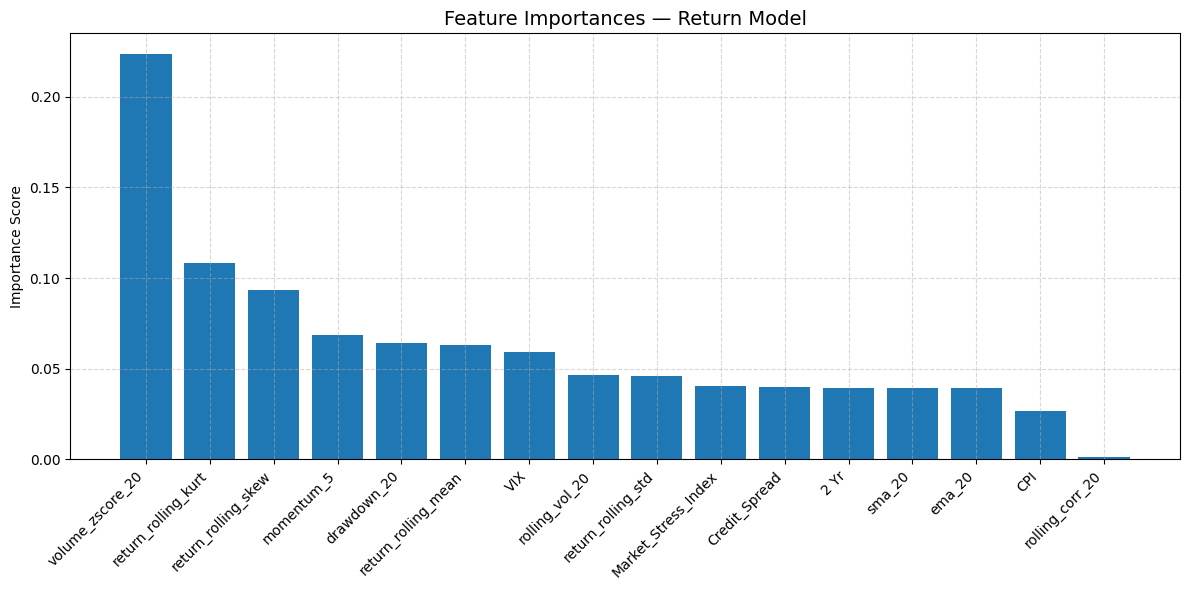

In [10]:
import matplotlib.pyplot as plt
import numpy as np

importances = model_2.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances — Return Model", fontsize=14)
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)),
           [return_feature_cols[i] for i in indices],
           rotation=45, ha='right')
plt.ylabel("Importance Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Reduced Model: Top 8 Feature Selection


In [11]:
# Reduced Model: Top 8 Feature Selection
top8_features = [
    'volume_zscore_20', 'return_rolling_kurt', 'return_rolling_skew',
    'momentum_5', 'drawdown_20', 'return_rolling_mean', 'VIX', 'rolling_vol_20'
]

X_top8 = df[top8_features]
y_top8 = df['label_return']

# Remove missing values
X_top8_clean = X_top8.dropna()
y_top8_clean = y_top8.loc[X_top8_clean.index]

valid_idx = y_top8_clean.dropna().index
X_top8_clean = X_top8_clean.loc[valid_idx]
y_top8_clean = y_top8_clean.loc[valid_idx]

X_train_top8, X_test_top8, y_train_top8, y_test_top8 = train_test_split(
    X_top8_clean, y_top8_clean, test_size=0.2, stratify=y_top8_clean, random_state=42
)

model_top8 = RandomForestClassifier(
    n_estimators=100, class_weight={0:1, 1:5}, random_state=42
)
model_top8.fit(X_train_top8, y_train_top8)

y_proba_top8 = model_top8.predict_proba(X_test_top8)[:, 1]
y_pred_adj_top8 = (y_proba_top8 > 0.25).astype(int)

print("Random Forest with Top 8 Features (Threshold = 0.25):")
print("Confusion Matrix:\n", confusion_matrix(y_test_top8, y_pred_adj_top8))
print("Classification Report:\n", classification_report(y_test_top8, y_pred_adj_top8))

Random Forest with Top 8 Features (Threshold = 0.25):
Confusion Matrix:
 [[134949   2778]
 [  4303   2697]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97    137727
           1       0.49      0.39      0.43      7000

    accuracy                           0.95    144727
   macro avg       0.73      0.68      0.70    144727
weighted avg       0.95      0.95      0.95    144727



### Visualization: Anomaly Detection on a Sample Stock

This chart visualizes both true and predicted return anomaly events for AAP in 2020. Predicted anomalies are based on Model 2 with a classification threshold of 0.25, consistent with the model evaluation above.

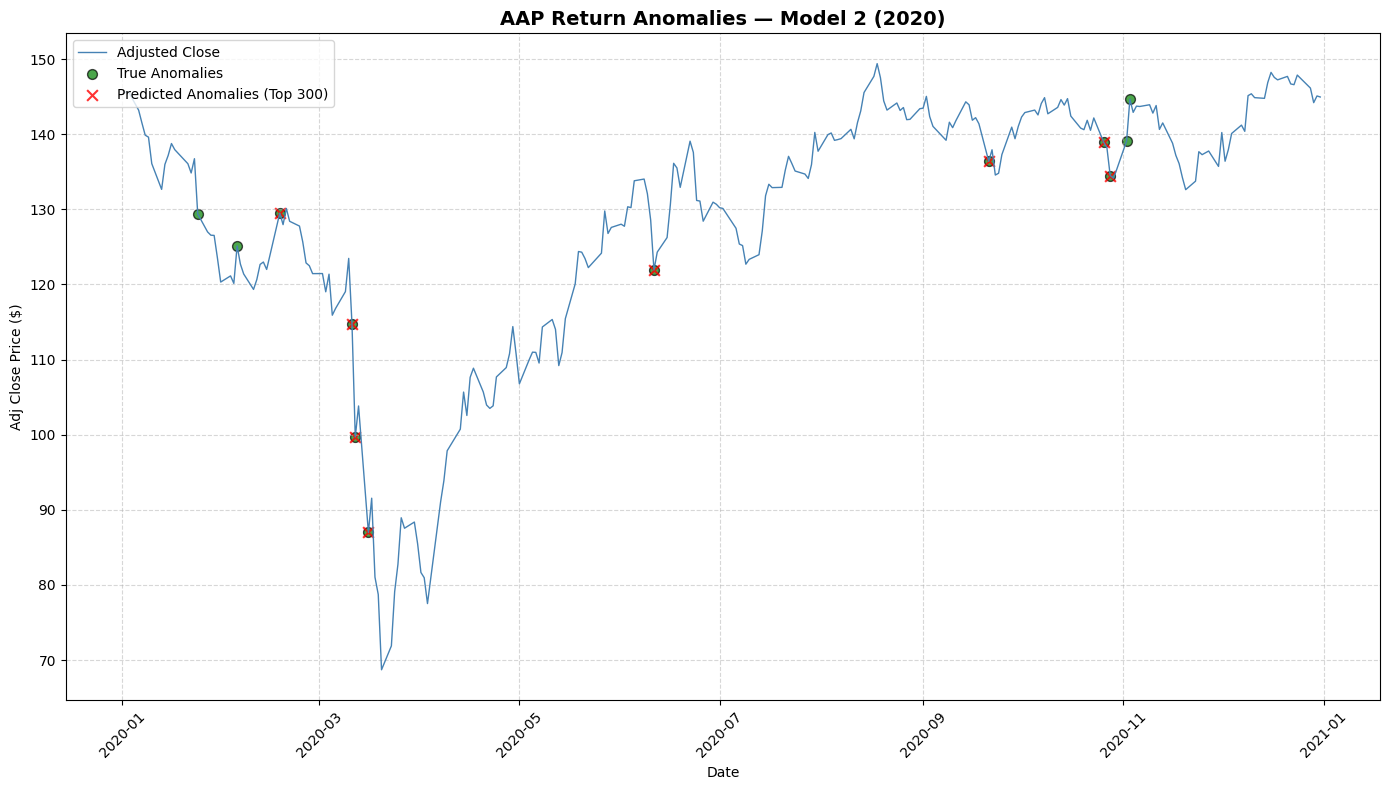

In [12]:
# Visualize return anomaly predictions for AAP in 2020
df_aap = df[(df['Ticker'] == 'AAP') & (df['Date'].dt.year == 2020)].copy()
df_aap = df_aap.dropna(subset=return_feature_cols + ['label_return'])

X_aap = df_aap[return_feature_cols]
y_proba_aap = model_2.predict_proba(X_aap)[:, 1]
df_aap['predicted_anomaly'] = (y_proba_aap > 0.25).astype(int)
df_aap['anomaly_prob'] = y_proba_aap

plt.figure(figsize=(14, 8))
plt.plot(df_aap['Date'], df_aap['Adj Close'], color='steelblue', label='Adjusted Close', linewidth=1)

# True anomalies (green circles)
true_anomalies = df_aap[df_aap['label_return'] == 1]
if not true_anomalies.empty:
    plt.scatter(true_anomalies['Date'], true_anomalies['Adj Close'],
                color='green', label='True Anomalies', s=50, alpha=0.7, edgecolor='black')

# Predicted anomalies (red x, top 300 by probability)
predicted = df_aap[df_aap['predicted_anomaly'] == 1]
top_pred = predicted.sort_values(by='anomaly_prob', ascending=False).head(300)
plt.scatter(top_pred['Date'], top_pred['Adj Close'],
            color='red', marker='x', s=60, alpha=0.8, label='Predicted Anomalies (Top 300)')

plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.title('AAP Return Anomalies — Model 2 (2020)', fontsize=14, weight='bold')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Lasso Feature Selection and Random Forest Retraining
This section applies Lasso regression to select the most relevant features for return anomaly detection, then retrains a Random Forest model on these selected features. Coefficient and feature importance visualizations provide further interpretability.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

# Remove missing values and prepare data
df_lasso = df.dropna(subset=return_feature_cols + ['label_return']).copy()
X = df_lasso[return_feature_cols]
y = df_lasso['label_return']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train LassoCV for feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Select features with non-zero coefficients
selected_features = [f for f, coef in zip(return_feature_cols, lasso.coef_) if abs(coef) > 1e-5]
print("Selected features by Lasso:\n", selected_features)


Selected features by Lasso:
 ['return_rolling_mean', 'return_rolling_std', 'return_rolling_skew', 'return_rolling_kurt', 'ema_20', 'momentum_5', 'rolling_vol_20', 'drawdown_20', 'volume_zscore_20', 'rolling_corr_20', '2 Yr', 'CPI', 'VIX', 'Credit_Spread', 'Market_Stress_Index']


In [14]:
# Train/test split for selected features
X_lasso = df_lasso[selected_features]
y_lasso = df_lasso['label_return']
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y_lasso, test_size=0.2, stratify=y_lasso, random_state=42)

# Train Random Forest model with class imbalance adjustment
rf_lasso = RandomForestClassifier(n_estimators=100, class_weight={0:1, 1:5}, random_state=42)
rf_lasso.fit(X_train, y_train)

# Standard prediction
y_pred = rf_lasso.predict(X_test)
print("Random Forest retrained on Lasso-selected features:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Adjust threshold to 0.25 for anomaly detection
y_proba = rf_lasso.predict_proba(X_test)[:, 1]
y_pred_adj = (y_proba > 0.25).astype(int)
print("Random Forest (Threshold = 0.25):")
print(confusion_matrix(y_test, y_pred_adj))
print(classification_report(y_test, y_pred_adj))

Random Forest retrained on Lasso-selected features:
[[2587    5]
 [ 124    6]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2592
           1       0.55      0.05      0.09       130

    accuracy                           0.95      2722
   macro avg       0.75      0.52      0.53      2722
weighted avg       0.93      0.95      0.93      2722

Random Forest (Threshold = 0.25):
[[2541   51]
 [ 105   25]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2592
           1       0.33      0.19      0.24       130

    accuracy                           0.94      2722
   macro avg       0.64      0.59      0.61      2722
weighted avg       0.93      0.94      0.94      2722



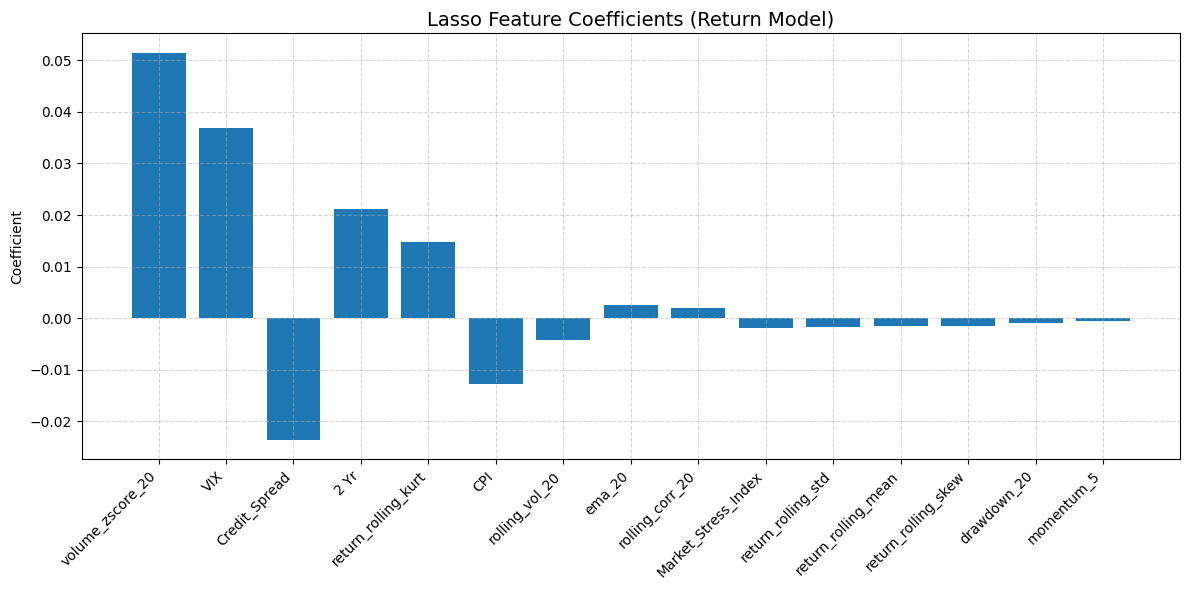

In [15]:
# Visualize non-zero Lasso coefficients
lasso_coefs = lasso.coef_
non_zero_idx = np.where(np.abs(lasso_coefs) > 1e-5)[0]
non_zero_coefs = lasso_coefs[non_zero_idx]
non_zero_names = [return_feature_cols[i] for i in non_zero_idx]

sorted_idx = np.argsort(np.abs(non_zero_coefs))[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(len(non_zero_coefs)), non_zero_coefs[sorted_idx], align='center')
plt.xticks(range(len(non_zero_coefs)), [non_zero_names[i] for i in sorted_idx], rotation=45, ha='right')
plt.title("Lasso Feature Coefficients (Return Model)", fontsize=14)
plt.ylabel("Coefficient")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


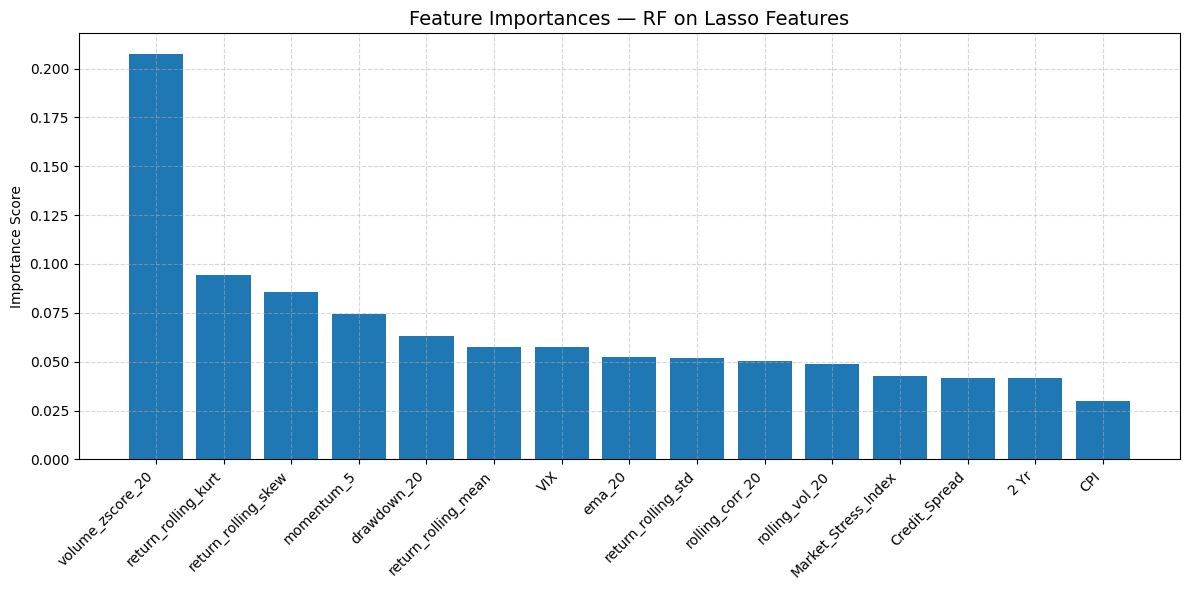

In [16]:
# Visualize feature importances from retrained Random Forest
importances = rf_lasso.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [selected_features[i] for i in indices], rotation=45, ha='right')
plt.title("Feature Importances — RF on Lasso Features", fontsize=14)
plt.ylabel("Importance Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Unsupervised Anomaly Detection: Isolation Forest
Isolation Forest is applied as an unsupervised benchmark for return anomaly detection.  
Results are compared against true labels to evaluate model precision and recall.


In [17]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Drop missing values
df_if_return = df.dropna(subset=return_feature_cols).copy()
X_if_return = df_if_return[return_feature_cols]

# Train Isolation Forest (unsupervised anomaly detection)
iso_return_model = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.05,  # Adjust to reflect expected anomaly rate
    random_state=42
)
iso_return_model.fit(X_if_return)

# Predict anomalies: -1 is anomaly, convert to 1 for consistency
df_if_return['iso_return_anomaly'] = (iso_return_model.predict(X_if_return) == -1).astype(int)

# If true labels exist, compare performance
if 'label_return' in df_if_return.columns:
    print("Isolation Forest vs. True Return Labels")
    print(confusion_matrix(df_if_return['label_return'], df_if_return['iso_return_anomaly']))
    print(classification_report(df_if_return['label_return'], df_if_return['iso_return_anomaly']))


Isolation Forest vs. True Return Labels
[[12353   603]
 [  572    78]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     12956
           1       0.11      0.12      0.12       650

    accuracy                           0.91     13606
   macro avg       0.54      0.54      0.54     13606
weighted avg       0.92      0.91      0.91     13606



### Isolation Forest with PCA Dimensionality Reduction
Principal Component Analysis (PCA) is used to reduce feature dimensionality prior to anomaly detection, preserving at least 88% of data variance.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Prepare data, remove missing values
df_if = df.dropna(subset=return_feature_cols + ['label_return']).copy()
X = df_if[return_feature_cols]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA dimensionality reduction (retain ~88% information)
pca = PCA(n_components=0.88)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA retained {X_pca.shape[1]} components.")

# Isolation Forest detection on PCA features
iso_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
y_iso = iso_model.fit_predict(X_pca)
df_if['return_anomaly_if_pca'] = (y_iso == -1).astype(int)  # -1 is anomaly

# Evaluate results
print("Return Anomalies — Isolation Forest + PCA")
print("Confusion Matrix:")
print(confusion_matrix(df_if['label_return'], df_if['return_anomaly_if_pca']))
print("Classification Report:")
print(classification_report(df_if['label_return'], df_if['return_anomaly_if_pca'], digits=2))

# Optional: Write PCA-based anomaly results back to main DataFrame
df.loc[df_if.index, 'return_anomaly_if_pca'] = df_if['return_anomaly_if_pca']


PCA retained 8 components.
Return Anomalies — Isolation Forest + PCA
Confusion Matrix:
[[12342   614]
 [  583    67]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     12956
           1       0.10      0.10      0.10       650

    accuracy                           0.91     13606
   macro avg       0.53      0.53      0.53     13606
weighted avg       0.91      0.91      0.91     13606



## Portfolio Backtest: Signal-Driven Return Filtering
This section applies the return anomaly model to construct a signal-driven equity portfolio. Daily anomaly signals are aggregated to filter portfolio exposure and the cumulative performance is compared with a static benchmark.

### Signal-Based Portfolio Construction

A sector-neutral, equal-weighted portfolio is constructed, and exposure is dynamically filtered using the model's aggregated anomaly scores.  
This approach aims to reduce drawdowns by avoiding high-risk days identified by the anomaly model.


In [19]:
# Standardize sector column
df.rename(columns={'GICS Sector': 'Sector'}, inplace=True)

# Calculate daily sector-level equal-weighted returns
sector_daily_return = (
    df.dropna(subset=['log_return', 'Sector'])
    .groupby(['Date', 'Sector'])['log_return']
    .mean()
    .reset_index()
)

# Calculate portfolio daily return as the average of all sector returns
portfolio_sector_weighted = (
    sector_daily_return
    .groupby('Date')['log_return']
    .mean()
    .reset_index()
    .rename(columns={'log_return': 'portfolio_log_return_sectorweighted'})
)

# Prepare model input: drop missing values for feature columns
df_return_model_input = df.dropna(subset=return_feature_cols).copy()
X_all = df_return_model_input[return_feature_cols]

# Predict anomaly probabilities with Random Forest (Model 2)
df_return_model_input['return_anomaly_prob'] = model_2.predict_proba(X_all)[:, 1]

# Assign binary anomaly label based on threshold (e.g., 0.2)
df_return_model_input['predicted_anomaly_rf'] = (df_return_model_input['return_anomaly_prob'] > 0.2).astype(int)

# Aggregate signal by date: proportion of stocks with no anomaly (signal = 1 means "hold")
df_signal = (
    df_return_model_input.groupby('Date')['predicted_anomaly_rf']
    .mean()
    .reset_index()
    .rename(columns={'predicted_anomaly_rf': 'anomaly_score'})
)

# Convert aggregated anomaly score into a trading signal (e.g., <0.25 is "low risk", hold; else, 0)
df_signal['signal'] = (df_signal['anomaly_score'] < 0.25).astype(int)

# Merge with benchmark sector-weighted portfolio return
df_signal = df_signal.merge(portfolio_sector_weighted, on='Date')

# Apply the signal: only invest on "low risk" days
df_signal['filtered_return'] = df_signal['portfolio_log_return_sectorweighted'] * df_signal['signal']

# Calculate cumulative returns for both portfolios
df_signal['benchmark_cum_return'] = (1 + df_signal['portfolio_log_return_sectorweighted']).cumprod()
df_signal['filtered_cum_return'] = (1 + df_signal['filtered_return']).cumprod()


### Performance on Cumulative Return

The plot below compares the cumulative returns of the benchmark portfolio with the signal-driven (filtered) portfolio.


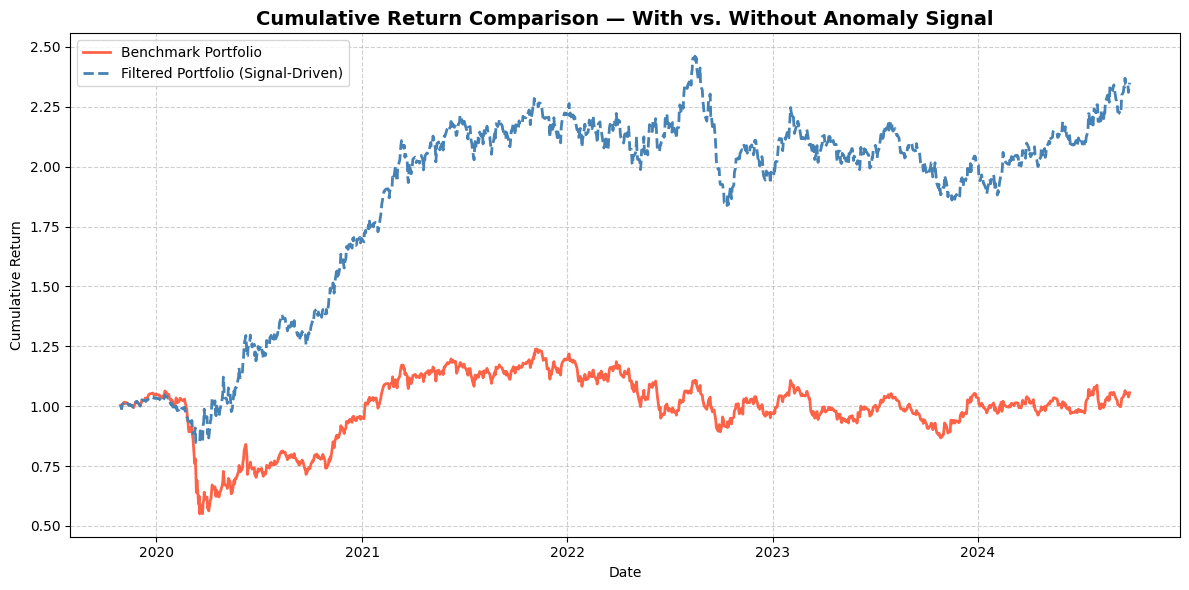

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.plot(df_signal['Date'], df_signal['benchmark_cum_return'], label='Benchmark Portfolio', linewidth=2, color='tomato')
plt.plot(df_signal['Date'], df_signal['filtered_cum_return'], label='Filtered Portfolio (Signal-Driven)', linestyle='--', linewidth=2, color='steelblue')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return Comparison — With vs. Without Anomaly Signal', fontsize=14, weight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [22]:
# Performance Metrics Calculation
def calculate_performance(returns, cum_returns, label):
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)
    def max_drawdown(cum):
        return (cum / cum.cummax() - 1).min()
    max_dd = max_drawdown(cum_returns)
    win_rate = (returns > 0).mean()
    print(f"\n{label}:")
    print(f"• Sharpe Ratio: {sharpe_ratio:.3f}")
    print(f"• Max Drawdown: {max_dd:.2%}")
    print(f"• Win Rate: {win_rate:.2%}")

# Compare signal-driven strategy and benchmark performance
filtered_returns = df_signal['filtered_return'].dropna()
benchmark_returns = df_signal['portfolio_log_return_sectorweighted'].dropna()

calculate_performance(filtered_returns, df_signal['filtered_cum_return'], 'Signal-Driven Strategy')
calculate_performance(benchmark_returns, df_signal['benchmark_cum_return'], 'Benchmark Portfolio')



Signal-Driven Strategy:
• Sharpe Ratio: 0.880
• Max Drawdown: -25.33%
• Win Rate: 49.15%

Benchmark Portfolio:
• Sharpe Ratio: 0.181
• Max Drawdown: -48.24%
• Win Rate: 50.85%


### Monte Carlo VaR Analysis
Monte Carlo simulation is used to estimate the 1-day and 10-day Value at Risk (VaR) for both the signal-driven and benchmark portfolios, using both parametric (normal distribution) and non-parametric (bootstrap) methods.

In [23]:
import numpy as np

# Parameters
num_simulations = 10000
confidence_level = 0.95
trading_days_list = [1, 10]  # 1-day and 10-day VaR

# Strategy returns
returns = filtered_returns.dropna().values

# Method 1: Parametric (Normal) Simulation
mu = returns.mean()
sigma = returns.std()

for d in trading_days_list:
    mu_d = mu * d
    sigma_d = sigma * np.sqrt(d)
    sim_ret_norm = np.random.normal(loc=mu_d, scale=sigma_d, size=num_simulations)
    var_95 = np.percentile(sim_ret_norm, (1 - confidence_level) * 100)
    print(f"{d}-day 95% Monte Carlo VaR (Signal-Driven, Normal): {var_95:.4%}")

# Method 2: Bootstrap (Historical Resampling)
for d in trading_days_list:
    sim_ret_boot = [
        np.sum(np.random.choice(returns, size=d, replace=True))
        for _ in range(num_simulations)
    ]
    var_95_boot = np.percentile(sim_ret_boot, (1 - confidence_level) * 100)
    print(f"{d}-day 95% Monte Carlo VaR (Signal-Driven, Bootstrap): {var_95_boot:.4%}")

# Benchmark Portfolio VaR Calculation
returns_bm = benchmark_returns.dropna().values

mu_bm = returns_bm.mean()
sigma_bm = returns_bm.std()

for d in trading_days_list:
    mu_d_bm = mu_bm * d
    sigma_d_bm = sigma_bm * np.sqrt(d)
    sim_ret_norm_bm = np.random.normal(loc=mu_d_bm, scale=sigma_d_bm, size=num_simulations)
    var_95_bm = np.percentile(sim_ret_norm_bm, (1 - confidence_level) * 100)
    print(f"{d}-day 95% Monte Carlo VaR (Benchmark, Normal): {var_95_bm:.4%}")

for d in trading_days_list:
    sim_ret_boot_bm = [
        np.sum(np.random.choice(returns_bm, size=d, replace=True))
        for _ in range(num_simulations)
    ]
    var_95_boot_bm = np.percentile(sim_ret_boot_bm, (1 - confidence_level) * 100)
    print(f"{d}-day 95% Monte Carlo VaR (Benchmark, Bootstrap): {var_95_boot_bm:.4%}")


1-day 95% Monte Carlo VaR (Signal-Driven, Normal): -2.3694%
10-day 95% Monte Carlo VaR (Signal-Driven, Normal): -6.5689%
1-day 95% Monte Carlo VaR (Signal-Driven, Bootstrap): -2.0840%
10-day 95% Monte Carlo VaR (Signal-Driven, Bootstrap): -6.5180%
1-day 95% Monte Carlo VaR (Benchmark, Normal): -2.9009%
10-day 95% Monte Carlo VaR (Benchmark, Normal): -8.9641%
1-day 95% Monte Carlo VaR (Benchmark, Bootstrap): -2.4315%
10-day 95% Monte Carlo VaR (Benchmark, Bootstrap): -8.9887%


### 13. Historical Stress Test
This analysis compares cumulative returns for the benchmark and signal-driven portfolios during the COVID-19 market crash (February–June 2020) and the 2022 interest rate hike regime (January–October 2022).
The goal is to evaluate the model's ability to mitigate drawdowns during periods of extreme market stress.


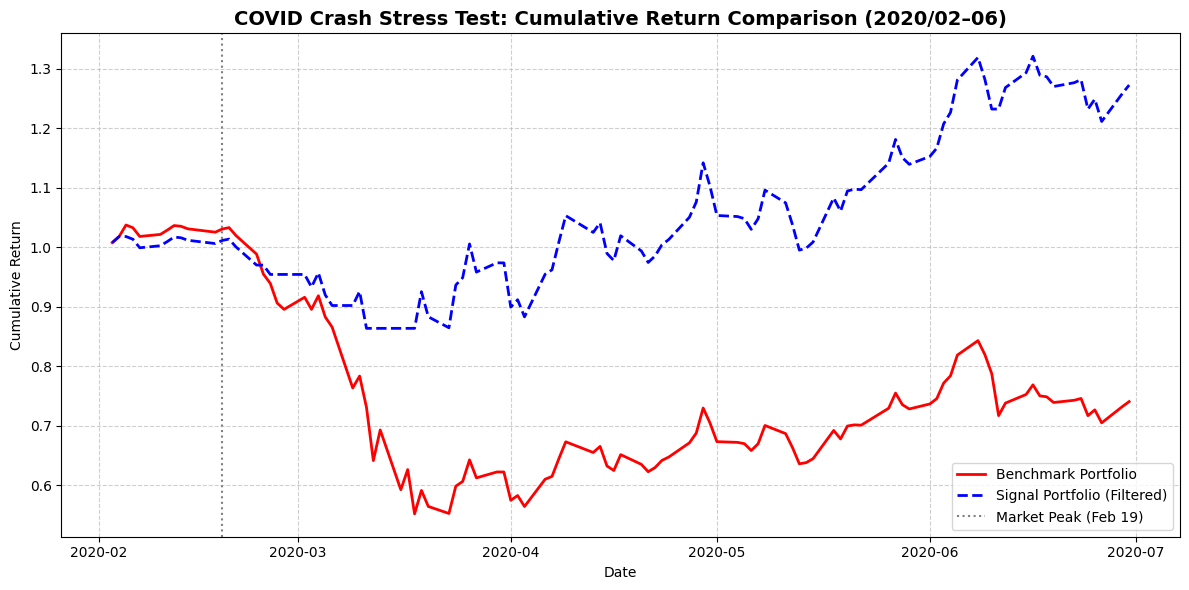

In [24]:
import matplotlib.pyplot as plt

# Filter for COVID-19 crash period (Feb–Jun 2020)
df_covid = df_signal[df_signal['Date'].between('2020-02-01', '2020-06-30')].copy()

# Recalculate cumulative returns for the selected period
df_covid['benchmark_cum_return'] = (1 + df_covid['portfolio_log_return_sectorweighted']).cumprod()
df_covid['filtered_cum_return'] = (1 + df_covid['filtered_return']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df_covid['Date'], df_covid['benchmark_cum_return'], label='Benchmark Portfolio', linewidth=2, color='red')
plt.plot(df_covid['Date'], df_covid['filtered_cum_return'], label='Signal Portfolio (Filtered)', linestyle='--', linewidth=2, color='blue')
plt.axvline(pd.to_datetime("2020-02-19"), color='gray', linestyle=':', label='Market Peak (Feb 19)')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("COVID Crash Stress Test: Cumulative Return Comparison (2020/02–06)", fontsize=14, weight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


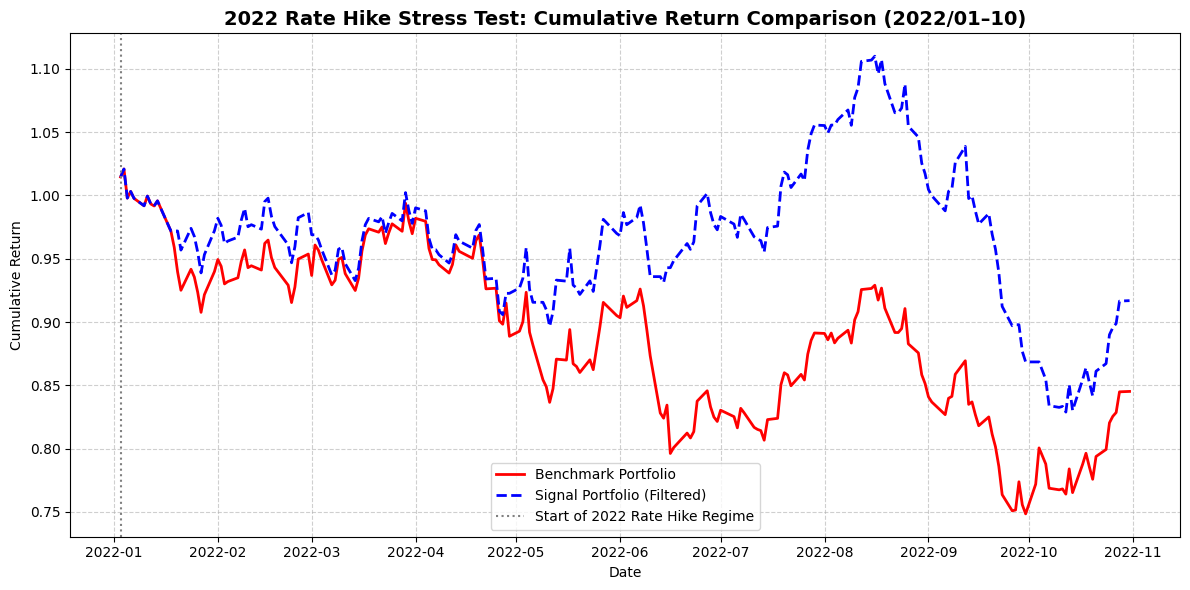

In [25]:
# Filter for 2022 rate hike regime (Jan–Oct 2022)
df_2022 = df_signal[df_signal['Date'].between('2022-01-01', '2022-10-31')].copy()

# Recalculate cumulative returns for the period
df_2022['benchmark_cum_return'] = (1 + df_2022['portfolio_log_return_sectorweighted']).cumprod()
df_2022['filtered_cum_return'] = (1 + df_2022['filtered_return']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df_2022['Date'], df_2022['benchmark_cum_return'], label='Benchmark Portfolio', linewidth=2, color='red')
plt.plot(df_2022['Date'], df_2022['filtered_cum_return'], label='Signal Portfolio (Filtered)', linestyle='--', linewidth=2, color='blue')
plt.axvline(pd.to_datetime("2022-01-03"), color='gray', linestyle=':', label='Start of 2022 Rate Hike Regime')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("2022 Rate Hike Stress Test: Cumulative Return Comparison (2022/01–10)", fontsize=14, weight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
